The objective of this model is to be able to predict the GradeClass.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [1]:
import sklearn
sklearn.__version__

'1.5.0'

In [17]:
data = pd.read_csv('data/Student_performance_data.csv')
data.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


# Exploratory Data Analysis


First of all, I will split the data in 3: training, validation and test.

In [18]:
X = data.drop(['GPA', 'GradeClass'], axis=1)
y = data[['GradeClass']]

In [19]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [20]:
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)

Notes about the columns:

- The StudentID will be removed to avoid biases in the grade calculation.
- Age, Gender and Ethnicity will be dropped to avoid bias, but this must be consider in the posterior evaluation and to comply with the Responsible AI.

- StudyTimeWeekly and Absences need to be scaled. I will check if they are normally distributed.


Extra considerations:

- For the preprocessing, I will expect a dictionary with all the columns presented in the original dataframe, even though several of them will be dropped.
- Non missing values are expected.


## Preprocessing

Conclusions for the features :

- ParentalEducation and ParentalSupport are ordinal categorical variables and will be transformed with a MinMaxScaler.
- Since StudyTimeWeekly and Absences are more similar to uniform distribution than to a normal one, I will use the MinMaxScaler for both of them.

I will convert GradeClass through OneHotEncoding

In [21]:
data.columns

Index(['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation',
       'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport',
       'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA',
       'GradeClass'],
      dtype='object')

In [22]:
from sklearn.preprocessing import MinMaxScaler


def training_preprocessing(data):
    columns_to_consider = ['ParentalEducation', 'StudyTimeWeekly', 'Absences', 
                           'Tutoring', 'ParentalSupport', 'Extracurricular', 
                           'Sports', 'Music', 'Volunteering']
    new_data = data.loc[:, columns_to_consider]
    minmax_cols = ['ParentalEducation', 'StudyTimeWeekly',
                'Absences', 'ParentalSupport']
    sc = MinMaxScaler()
    x_sc = sc.fit_transform(new_data.loc[:, minmax_cols])
    return x_sc, sc
    


In [31]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(sparse_output=False)
ohe.fit_transform(y_train)

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [23]:
X_train.isna().sum()


StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
dtype: int64

<Axes: >

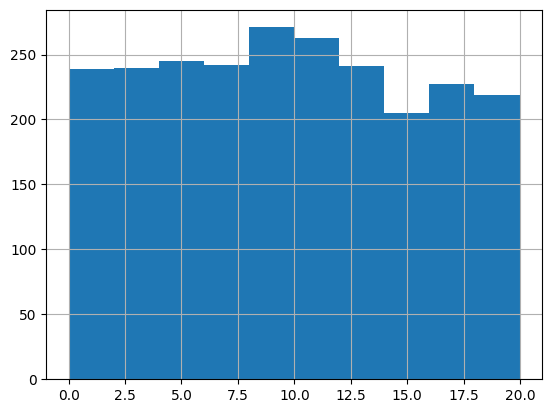

In [24]:
data.StudyTimeWeekly.hist()

<Axes: >

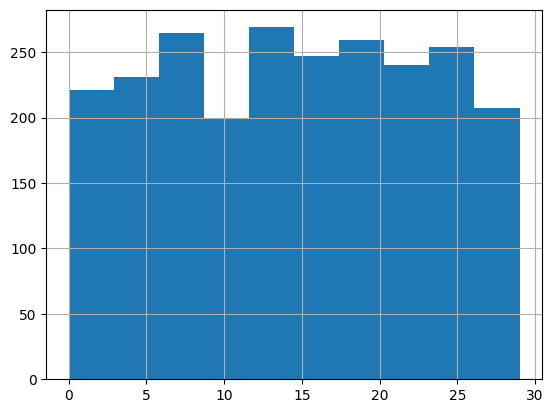

In [25]:
data.Absences.hist()

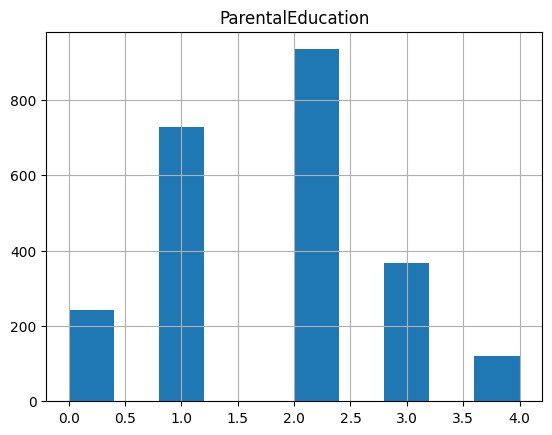

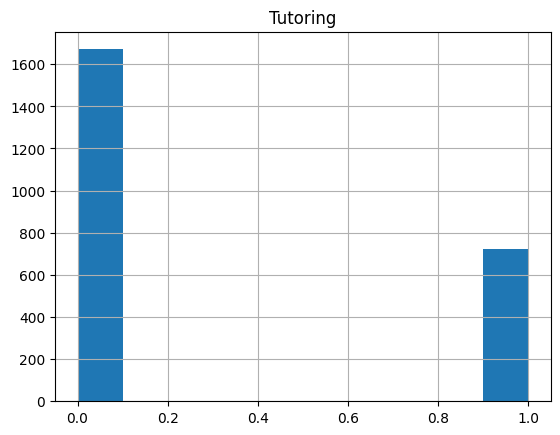

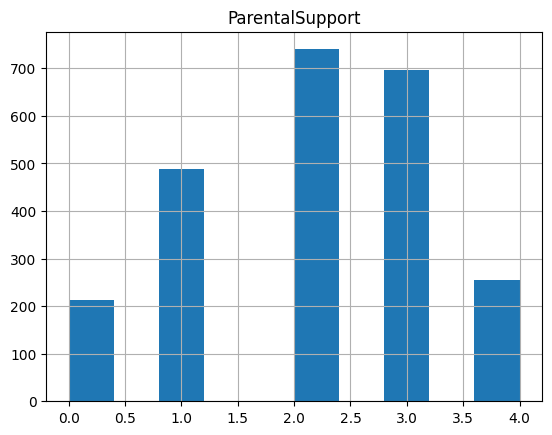

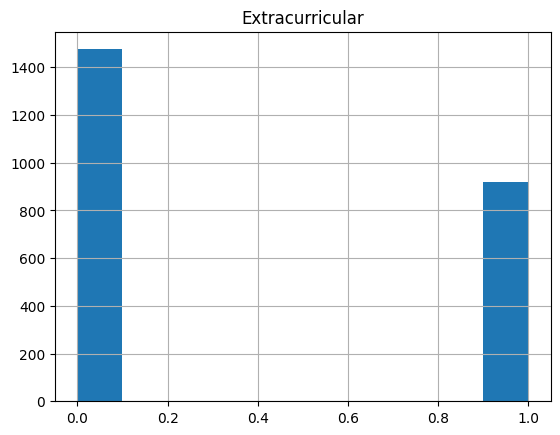

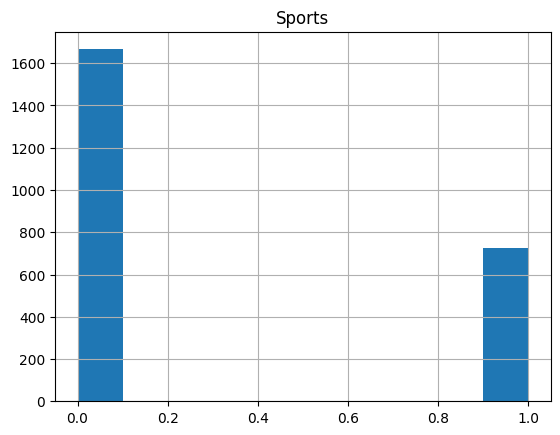

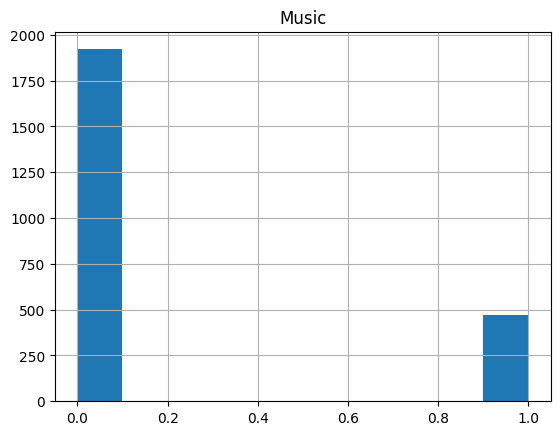

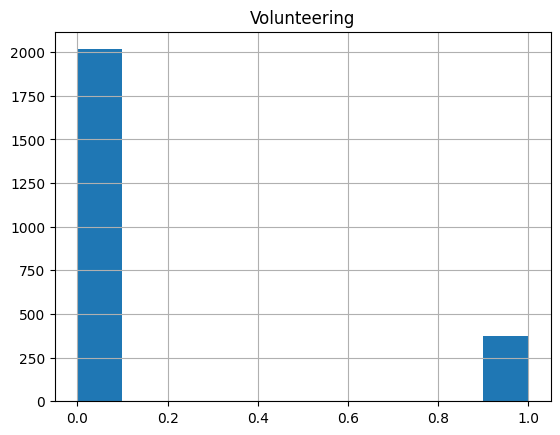

In [26]:
cat_columns = ['ParentalEducation', 'Tutoring', 'ParentalSupport',
                'Extracurricular', 'Sports', 'Music', 'Volunteering']


for col in cat_columns: 
    data[[col]].hist()

In [28]:
import scipy.stats as stats

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
param_dists = [{
    'clf': [SVC()],
    'clf__C': [0.001, 0.1, 1, 10, 100, 10e5],
    'clf__kernel': ['linear', 'rbf'],
    'clf__class_weight': ['balanced'],
    'clf__probability': [True]
},
{
    'clf': [DecisionTreeClassifier()],
    'clf__criterion': ['gini','entropy'],
    'clf__splitter': ['best','random'],
    'clf__class_weight':['balanced', None]
},
{
    "clf": [SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True)],
    "clf__average": [True, False],
    "clf__l1_ratio": stats.uniform(0, 1),
    "clf__alpha": stats.loguniform(1e-2, 1e0),
}]

In [ ]:
n_iter_search = 15
n_cv = 3

for param_dist in param_dists:
    clf = param_dist['clf'][0]
    
    param_dist.pop('clf')
    steps = [('clf', clf)]
    random_search = RandomizedSearchCV(
        Pipeline(steps), param_grid=param_dist, cv=n_cv, n_iter=n_iter_search
    )
    random_search.fit(scaled_data)
